# Backtesting a cross-sectional mean reversion trading strategy

In this notebook, we will backtest a cross-sectional mean reversion trading strategy, taken from Ernest Chan's book [Algorithmic Trading: Winning Strategies and Their Rationale](https://www.amazon.com/Algorithmic-Trading-Winning-Strategies-Rationale/dp/1118460146/ref=sr_1_1?keywords=Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale&qid=1560084760&s=books&sr=1-1).

I suggest for anyone looking to to get into algorithmic trading to also read Chan's other book [Quantitative Trading: How to Build Your Own Algorithmic Trading Business](https://www.amazon.co.uk/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889).


## What is a mean reversion strategy?
Mean-reversion strategies work on the assumption that there is an underlying stable trend in the price of an asset and prices fluctuate randomly around this trend. Therefore, values deviating far from the trend will tend to reverse direction and revert back to the trend. That is, if the value is unusually high, we expect it to go back down and if it is unusually low, go back up. <br>
![image](Images/mean_reversion.png)

A cross-sectional mean reversion strategy extends on this, by proposing that stocks behave like the stocks they are *historically* correlated to.
![](Images/cross_mean_reversion.png)

The strategy described in Chan’s book is as follows: Everyday, every stock *i* in the universe is assigned a weight *w_i* according to the following formula: <br>
![](Images/formula.png)<br>

Where *r_m* is the mean returns of the universe. This weight will tell us how much of the portfolio will be long or short that particular stock. As we can see in the formula, the farther an individual stock’s returns are from the mean, the greater its weight will be.

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt
from datetime import datetime
import os


In [2]:
%matplotlib inline
sns.set()
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 18,9
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()
plt.style.use('fivethirtyeight')

# Data
For this analysis, we consider the S&P 500 stocks as our universe. We will use *pandas_datareader* module to download stocks from [IEX](https://iextrading.com/), you can also use yahoo finance.

In [5]:
#Load in your data from

data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table = data[0]
table['Symbol'] = table['Symbol'].str.replace('.', '-')
tickers = table['Symbol'].to_list()
#pd.Series(tickers).to_csv("../data/tickers.csv")

In order to speed up this process, use the python's multi-threading __*concurrent.futures.ThreadPoolExecutor*__

In [10]:
from concurrent import futures

end = datetime.now()
start = datetime(end.year - 3, end.month , end.day)
bad = []

In [11]:
#%%time
#def download(ticker):
#    df = web.DataReader(name= ticker,data_source='yahoo', start=start, end=end)
#    df.to_csv(f"../data/ticks/{ticker}.csv")
#
#with futures.ThreadPoolExecutor(100) as executor:
#    res = executor.map(download, tickers)

Next define the strategy:

In [12]:
class CrossSectionalMR(bt.Strategy):
    def prenext(self):
        self.next()

    def next(self):
        # only look at data that existed yesterday
        available = list(filter(lambda d: len(d), self.datas))

        rets = np.zeros(len(available))
        for i, d in enumerate(available):
            # calculate individual daily returns
            rets[i] = (d.close[0]- d.close[-1]) / d.close[-1]

        # calculate weights using formula
        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        weights = weights / np.sum(np.abs(weights))

        for i, d in enumerate(available):
            self.order_target_percent(d, target=weights[i])

Note: It is worth mentioning that Backtrader only calls a strategy’s next() method when it has a price tick from every data feed. This means that by default the strategy will not trade if, for example, a company in the universe has not started trading publicly yet. We can circumvent this issue by calling next() in prenext() and then applying the weight calculation formula to only stocks in which we have data to.

Now backtest the strategy using [Backtrader](https://www.backtrader.com/), assuming 1m of initial capital:

In [19]:
%%time
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

for ticker in tickers[:15]:
    data = bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=(f"../data/ticks/{ticker}.csv"),
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=False
    )
    cerebro.adddata(data)

cerebro.broker.setcash(1_000_000)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(CrossSectionalMR)
results = cerebro.run()

CPU times: user 5.33 s, sys: 0 ns, total: 5.33 s
Wall time: 5.42 s


In [20]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")


Sharpe: 0.781
Norm. Annual Return: 10.67%
Max Drawdown: 17.22%


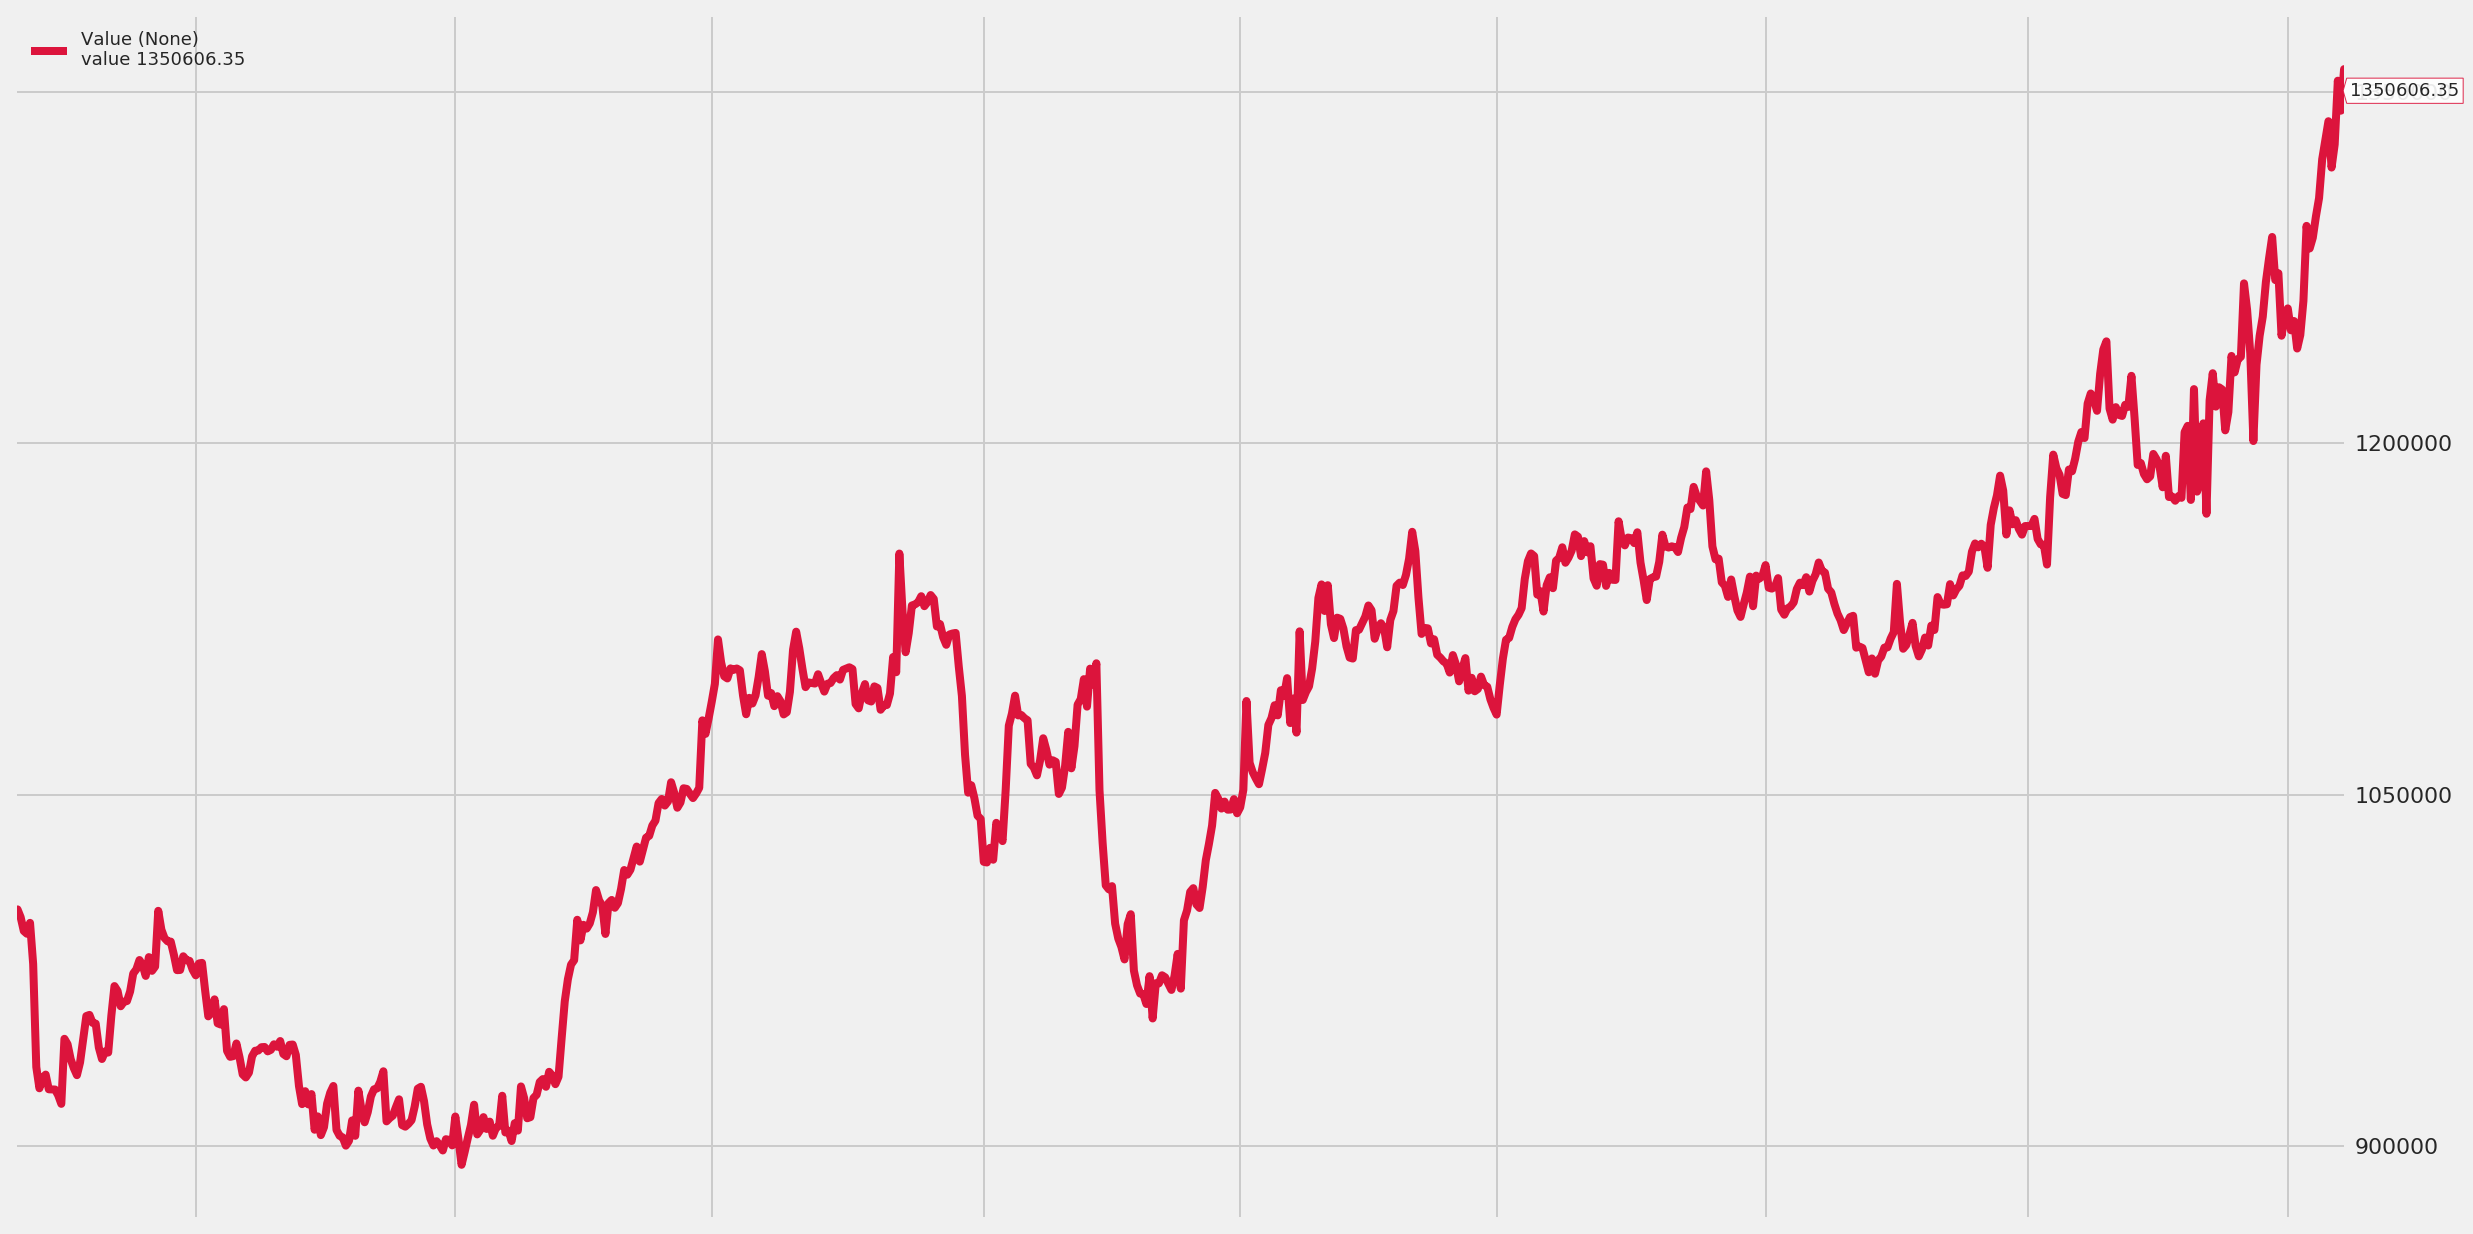

[[<Figure size 1296x648 with 1 Axes>]]

In [21]:
cerebro.plot(iplot=False)

# Results
Not bad! The strategy returns a Sharpe ratio of 1.484 with an  normalised annual return of %7.50. While not much better than buying and holding an SPY index, the volatility is greatly reduced (as noted by the drawdown amount). <br>

A few points to take into account with this strategy, (before planning your retirement in Barbados!):<br>

* __Transaction costs__: We have assumed 0 transaction costs for every trade in this strategy, adding this in will dramatically change the strategy. This can be countered by altering the trade strategy to only buy/sell the most volatile moves, rather than all moves.<br> 

* __Survivorship bias__: The dataset does not take into account companies that have moved in/out of the S&P index in the time period we backtested for. Using a survivorship bias free data-set will ensure the backtest results are more robust. <br>

* __Capital__: Since every stock is being traded in this strategy, the investor will need a large initial outlay for the strategy to work.<br>

# Chapter 2: Improvement

In [57]:
datas = [bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=(f"../data/ticks/{ticker}.csv"),
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=False
    ) for ticker in tickers[:500]]

In [58]:
def backtest(datas, strategy, plot=None, **kwargs):
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.broker.set_coc(True)
    cerebro.broker.setcash(1_000_000)
    for data in datas:
        cerebro.adddata(data)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    results = cerebro.run()
    if plot:
        cerebro.plot(iplot=False)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

### Number of Positions
One of the limitations of the strategy above was the number of positions it held at once. If the strategy was given a universe of 500 stocks, it would trade all of them. Not only would this rack up commission charges, it would be difficult to match the calculated weights in the portfolio without a very large amount of capital. The solution to this is fairly straightforward. While we are calculating the weights, we can simply choose the n stocks with the highest absolute weight. 


### Volatility Filter
Now we will try using the same weight formula, but only trade stocks that are in the top n sorted by weight, and in the bottom n, sorted by 5-day standard deviation. In this way we will only trade stocks that have a comparatively high diversion from the mean returns of the universe, and comparatively low volatility.

In [59]:
def min_n(array, n):
    return np.argpartition(array, n)[:n]

def max_n(array, n):
    return np.argpartition(array, -n)[-n:]

class CrossSectionalMR(bt.Strategy):
    params = dict(
            n=50,
            pe=5)
    
    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {}
            self.inds[d]["pct"] = bt.indicators.PercentChange(d.close, period=self.p.pe)
            self.inds[d]["std"] = bt.indicators.StandardDeviation(d.close, period=self.p.pe)

    def prenext(self):
        self.next()
    
    def next(self):
        available = list(filter(lambda d: len(d) > self.p.pe, self.datas)) # only look at data that existed last week
        rets = np.zeros(len(available))
        stds = np.zeros(len(available))
        for i, d in enumerate(available):
            rets[i] = self.inds[d]['pct'][0]
            stds[i] = self.inds[d]['std'][0]

        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        max_weights_index = max_n(np.abs(weights), self.p.n)
        low_volality_index = min_n(stds, self.p.n)
        selected_weights_index = np.intersect1d(max_weights_index,
                                                low_volality_index)
        if not len(selected_weights_index):
            # no good trades today
            return
            
        selected_weights = weights[selected_weights_index]
        weights = weights / np.sum(np.abs(selected_weights))      
        for i, d in enumerate(available):
            if i in selected_weights_index:
                self.order_target_percent(d, target=weights[i])
            else:
                self.order_target_percent(d, 0)

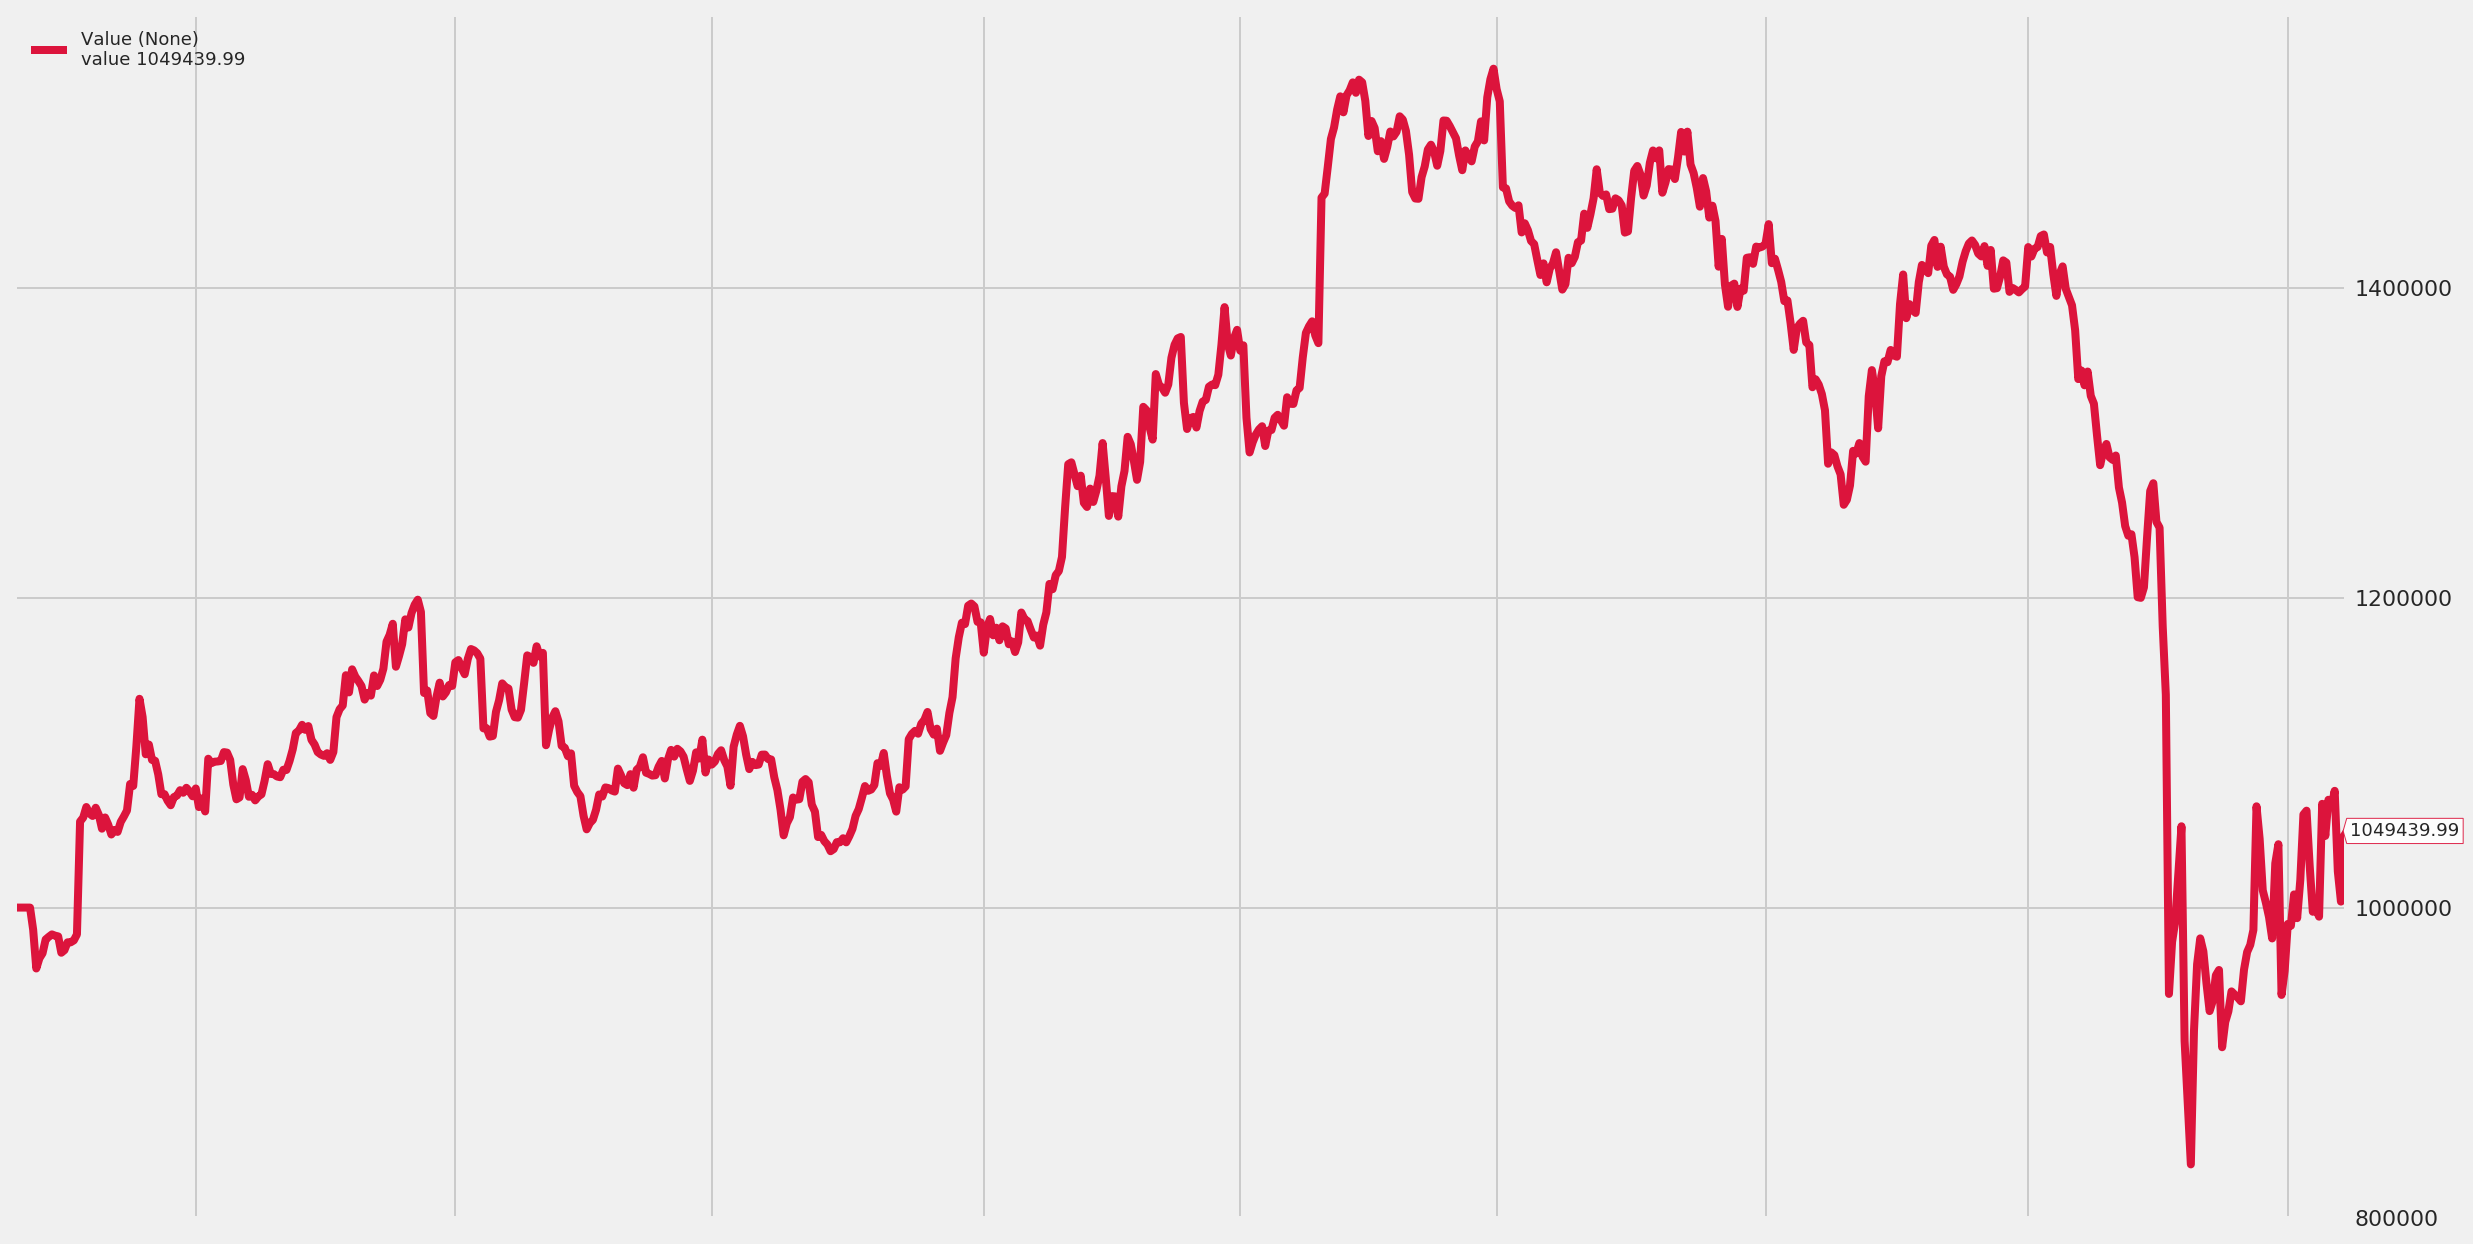

Max Drawdown: 45.86%
APR: 1.64%
Sharpe: 0.163
CPU times: user 1min 8s, sys: 476 ms, total: 1min 9s
Wall time: 1min 11s


In [60]:
%%time
dd, cagr, sharpe = backtest(datas, CrossSectionalMR, plot=True, n=100)
print(f"Max Drawdown: {dd:.2f}%\nAPR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")